# *Interpretation of Generalization in Masked Language Models: An Investigation Straddling Quantifiers and Generics* (Clic-it 2023)

Authors: Claudia Collacciani, Giulia Rambelli


<a target="_blank" href="https://colab.research.google.com/github/claudiacollacciani/Interpretation-of-Generalization-in-Masked-Language-Models/blob/main/experiments.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from transformers import pipeline

In [ ]:
models = ['bert-base-uncased', 'bert-large-uncased', 'roberta-base', 'roberta-large']
# change path according to where your files are stored
datasets_folder = './datasets/'
results_folder = './results/'

## **Experiment 1: Probability distribution of Quantifiers in MLMs**

Extract conditional probabilities

In [ ]:
dataset = datasets_folder+'207_generics_subset.tsv'

In [ ]:
processed_dataset = []

cc = Counter()
for line in open(dataset, 'r'):
  sample = line.strip().split("\t")
  processed_dataset.append(sample)

print("Number of samples:", len(processed_dataset))
print()

print("Input sample:", processed_dataset[206])

Number of samples: 207

Input sample: ['Alligators are faster than humans on land.', 'invirtue', 'Alligators']


In [ ]:
result_dfs = {}

for model in models:

  nlp = pipeline("fill-mask", model=model)

  columns = ["gen_sent", "category", "subject", "masked_sent",
             "few_prob", "some_prob", "many_prob", "most_prob", "all_prob"]

  result_dfs[model] = pd.DataFrame(columns=columns)

  for input_sample in processed_dataset:
    if 'roberta' in model:
      mask = '<mask> '
    else:
      mask = '[MASK] '
    sentence = mask + input_sample[0].lower()

    targets = ("few", "some", "many", "most", "all")
    dict_results = {"gen_sent":[input_sample[0]],
                    "category": [input_sample[1]],
                    "subject": [input_sample[2]],
                    "masked_sent": [sentence]}

    # Get predictions and store them in the dictionary
    predictions = nlp(sentence, targets=targets)

    for pred in predictions:
      token = pred["token_str"]
      prob = pred["score"]
      if token == "few":
        dict_results["few_prob"] = [prob]
      elif token == "some":
        dict_results["some_prob"] = [prob]
      elif token == "many":
        dict_results["many_prob"] = [prob]
      elif token == "most":
        dict_results["most_prob"] = [prob]
      else:
        dict_results["all_prob"] = [prob]

    result_dfs[model] = pd.concat([result_dfs[model], pd.DataFrame(dict_results)])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for model, result_df in result_dfs.items():
    result_df.to_csv(results_folder + model + "_results_exp1.csv", sep='\t', index=False)

Visualize log probabilities

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

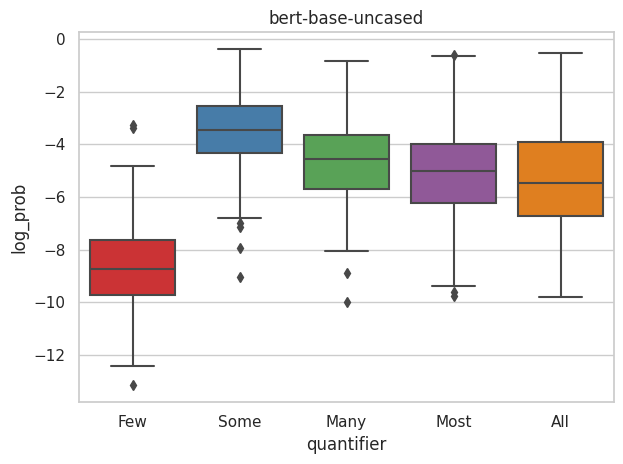

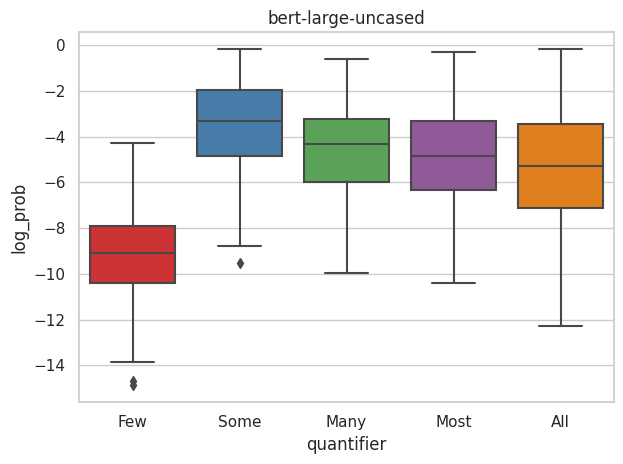

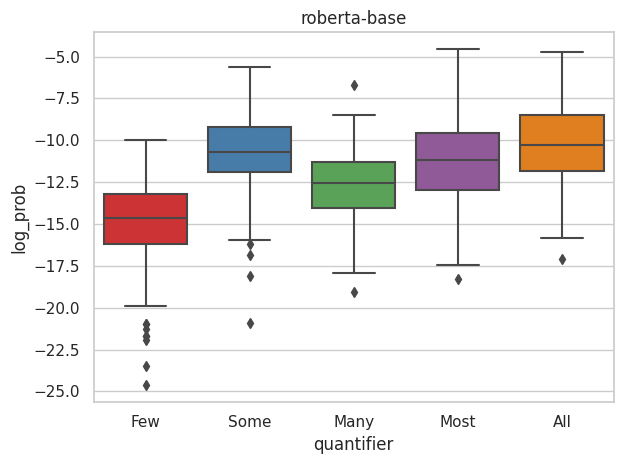

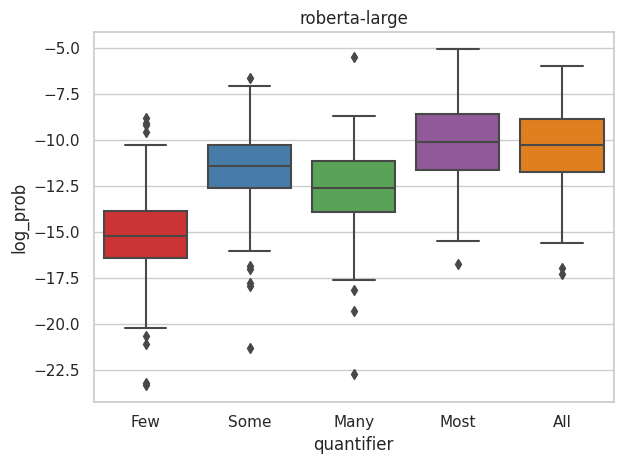

In [ ]:
boxplots = []

for model in models:
    result_df = pd.read_csv(results_folder + model + "_results_exp1.csv", sep='\t')

    data = result_df.iloc[:, -5:]
    data = data.melt(var_name='quantifier', value_name='prob')
    data['prob'] = np.log(data['prob'])

    sns.set(style='whitegrid')
    sns.set_palette("Set1")
    plt.figure()
    ax = sns.boxplot(data=data, x='quantifier', y='prob')
    plt.xlabel('quantifier')
    plt.ylabel('log_prob')
    ax.set_xticklabels(["Few", "Some", "Many", "Most", "All"])
    plt.title(f'{model}')
    plt.tight_layout()

    boxplots.append(plt)

for boxplot in boxplots:
    boxplot.show()

## **Experiment 2: Representation of words in Generics and Quantified Sentences**

Extract internal representations

In [ ]:
import os
import pickle
import torch

# AutoModel and AutoTokenizer for loading the Transformer model (and the corresponding tokenizer) via Huggingface's Transformers library
from transformers import AutoModel, AutoTokenizer

# Imports for the probing model
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.dummy import DummyRegressor

from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr

In [ ]:
dataset2 = datasets_folder+'generic_quant_sents.txt'

In [ ]:
sents = []
targs = []
with open(dataset2, 'r') as f:
  for line in f:
      items = line.strip().split('\t')
      sents.append(items[0])
      targs.append(int(items[1]))

In [ ]:
def get_representation(sentences_list, targets_list, model, tokenizer, output_file, aggregation="average"):
  embeddings = []
  ids = []
  sentences = []
  targets = []
  CLSs = []

  for c, (sentence, pos) in enumerate(zip(sentences_list,targets_list)):
    print(c,sentence, pos)

    sent_id = c
    # Tokenization of the sentence
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)


    map_token_word = tokenizer(sentence,add_special_tokens=True).words()
    ids_target = [c for c,i in enumerate(map_token_word) if i ==pos]

    # Print the sentence and the target
    print('Extracting representations from model')
    print("Sentence:", sentence)
    print('Original:', sentence.split(' '))
    print('Tokenized ids: ', input_ids)
    print('Tokenized tokens:', [tokenizer.decode(id) for id in input_ids])
    print('Subtokens mapping', [i for i in map_token_word])
    print("Target token:", ids_target)

    input_ids = torch.tensor([input_ids]).to(device)

    # Extraction of the representations
    with torch.no_grad():
      outputs = model(input_ids)
      hstates = outputs["hidden_states"]
      embeddings.append(outputs["hidden_states"])

      # extract targeted representations

      # Number of layers of the model
      n_layers = len(hstates)
      #print(n_layers)
      cls_dic = {}
      target_dic = {}
      for layer_id in range(0, n_layers):
        hidden_state = hstates[layer_id]
        cls_dic[layer_id] = hidden_state[0][0].cpu().numpy()
        target_dic[layer_id]=np.average([hidden_state[0][i].cpu().numpy() for i in ids_target],axis=0)
        #print(layer_id, ids_target)
      CLSs.append(cls_dic)
      targets.append(target_dic)
    ids.append(sent_id)
    sentences.append(sentence)

  with open(output_file, "wb") as fout:
    pickle.dump({'ids': ids, 'sentences': sentences,'pos_target': targets_list, 'target_embeddings': targets, 'CLS_embeddings':CLSs}, fout)
  return embeddings

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

for model in models:

  # Loading the tokenizer and the model via Huggingface's Transformers library
  tokenizer = AutoTokenizer.from_pretrained(model)

  # 'output_hidden_states=True' because we want to extract the representations from all the layers of the model
  model_obj = AutoModel.from_pretrained(model, output_hidden_states=True)
  model_obj = model_obj.to(device)

  result_filename = results_folder + model + "_representation.pkl"

  representations = get_representation(sents, targs, model_obj, tokenizer, result_filename)

0 telephones are used to communicate with the outside world. 0
Extracting representations from model
Sentence: telephones are used to communicate with the outside world.
Original: ['telephones', 'are', 'used', 'to', 'communicate', 'with', 'the', 'outside', 'world.']
Tokenized ids:  [101, 7026, 2015, 2024, 2109, 2000, 10639, 2007, 1996, 2648, 2088, 1012, 102]
Tokenized tokens: ['[CLS]', 'telephone', '##s', 'are', 'used', 'to', 'communicate', 'with', 'the', 'outside', 'world', '.', '[SEP]']
Subtokens mapping [None, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, None]
Target token: [1, 2]
1 few telephones are used to communicate with the outside world. 1
Extracting representations from model
Sentence: few telephones are used to communicate with the outside world.
Original: ['few', 'telephones', 'are', 'used', 'to', 'communicate', 'with', 'the', 'outside', 'world.']
Tokenized ids:  [101, 2261, 7026, 2015, 2024, 2109, 2000, 10639, 2007, 1996, 2648, 2088, 1012, 102]
Tokenized tokens: ['[CLS]', 'few', 'tel

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:360: FutureWarning: `BatchEncoding.words()` property is deprecated and should be replaced with the identical, but more self-explanatory `BatchEncoding.word_ids()` property.
  warnings.warn(


Output streaming troncato alle ultime 5000 righe.
617 all abbeys have their own chapel. 1
Extracting representations from model
Sentence: all abbeys have their own chapel.
Original: ['all', 'abbeys', 'have', 'their', 'own', 'chapel.']
Tokenized ids:  [101, 2035, 6103, 2015, 2031, 2037, 2219, 4970, 1012, 102]
Tokenized tokens: ['[CLS]', 'all', 'abbey', '##s', 'have', 'their', 'own', 'chapel', '.', '[SEP]']
Subtokens mapping [None, 0, 1, 1, 2, 3, 4, 5, 6, None]
Target token: [2, 3]
618 stomachs are an important part of the body. 0
Extracting representations from model
Sentence: stomachs are an important part of the body.
Original: ['stomachs', 'are', 'an', 'important', 'part', 'of', 'the', 'body.']
Tokenized ids:  [101, 4308, 2015, 2024, 2019, 2590, 2112, 1997, 1996, 2303, 1012, 102]
Tokenized tokens: ['[CLS]', 'stomach', '##s', 'are', 'an', 'important', 'part', 'of', 'the', 'body', '.', '[SEP]']
Subtokens mapping [None, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, None]
Target token: [1, 2]
619 few st

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Output streaming troncato alle ultime 5000 righe.
617 all abbeys have their own chapel. 1
Extracting representations from model
Sentence: all abbeys have their own chapel.
Original: ['all', 'abbeys', 'have', 'their', 'own', 'chapel.']
Tokenized ids:  [0, 1250, 4091, 1610, 2459, 33, 49, 308, 27070, 4, 2]
Tokenized tokens: ['<s>', 'all', ' ab', 'be', 'ys', ' have', ' their', ' own', ' chapel', '.', '</s>']
Subtokens mapping [None, 0, 1, 1, 1, 2, 3, 4, 5, 6, None]
Target token: [2, 3, 4]
618 stomachs are an important part of the body. 0
Extracting representations from model
Sentence: stomachs are an important part of the body.
Original: ['stomachs', 'are', 'an', 'important', 'part', 'of', 'the', 'body.']
Tokenized ids:  [0, 620, 44637, 29, 32, 41, 505, 233, 9, 5, 809, 4, 2]
Tokenized tokens: ['<s>', 'st', 'omach', 's', ' are', ' an', ' important', ' part', ' of', ' the', ' body', '.', '</s>']
Subtokens mapping [None, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, None]
Target token: [1, 2, 3]
619 few s

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Output streaming troncato alle ultime 5000 righe.
617 all abbeys have their own chapel. 1
Extracting representations from model
Sentence: all abbeys have their own chapel.
Original: ['all', 'abbeys', 'have', 'their', 'own', 'chapel.']
Tokenized ids:  [0, 1250, 4091, 1610, 2459, 33, 49, 308, 27070, 4, 2]
Tokenized tokens: ['<s>', 'all', ' ab', 'be', 'ys', ' have', ' their', ' own', ' chapel', '.', '</s>']
Subtokens mapping [None, 0, 1, 1, 1, 2, 3, 4, 5, 6, None]
Target token: [2, 3, 4]
618 stomachs are an important part of the body. 0
Extracting representations from model
Sentence: stomachs are an important part of the body.
Original: ['stomachs', 'are', 'an', 'important', 'part', 'of', 'the', 'body.']
Tokenized ids:  [0, 620, 44637, 29, 32, 41, 505, 233, 9, 5, 809, 4, 2]
Tokenized tokens: ['<s>', 'st', 'omach', 's', ' are', ' an', ' important', ' part', ' of', ' the', ' body', '.', '</s>']
Subtokens mapping [None, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, None]
Target token: [1, 2, 3]
619 few s

Compute Spearman correlation

In [ ]:
from scipy import stats

def compute_spearman_correlation(a, b):
    return stats.spearmanr(a, b).correlation

In [ ]:
complete_df = pd.read_csv(datasets_folder+'generic_quant_sents.csv', sep='\t')
cols_to_add = complete_df[['quantifier', 'category', 'subject']]

In [ ]:
dfs = {}

for model in models:
    obj = pd.read_pickle(results_folder + model + '_representation.pkl')
    df = pd.DataFrame(obj)
    df = pd.concat([df, cols_to_add], axis=1)

    dfs[model] = df

In [ ]:
spearman_dfs = {}

for model, df in dfs.items():
    layer_list = []
    couple_list = []
    spearman_correlation_list = []
    ids_list = []
    sentence_list = []
    category_list = []

    for i, row in df.iterrows():
        if row['quantifier'] == 'Gen':
            gen_dict = row['target_embeddings']
            gen_id = row['ids']
            gen_sentence = row['sentences']
            gen_category = row['category']
            for j in range(i + 1, i + 6):
                if df.loc[j, 'quantifier'] != 'Gen':
                    label = df.loc[j, 'quantifier']
                    target_dict = df.loc[j, 'target_embeddings']
                    for key in gen_dict.keys():
                        if key in target_dict:
                            gen_array = gen_dict[key]
                            target_array = target_dict[key]
                            correlation = compute_spearman_correlation(gen_array, target_array)
                            layer_list.append(key)
                            couple_list.append(f"Gen_{label}")
                            spearman_correlation_list.append(correlation)
                            ids_list.append(gen_id)
                            sentence_list.append(gen_sentence)
                            category_list.append(gen_category)

    spearman_df = pd.DataFrame({'ids': ids_list, 'sentence': sentence_list, 'category': category_list, 'layer': layer_list, 'quantifier': couple_list, 'spearman_correlation': spearman_correlation_list})
    spearman_dfs[model] = spearman_df

Visualization of Spearman correlation between internal representations of generic and quantified sentences, for each hidden layer

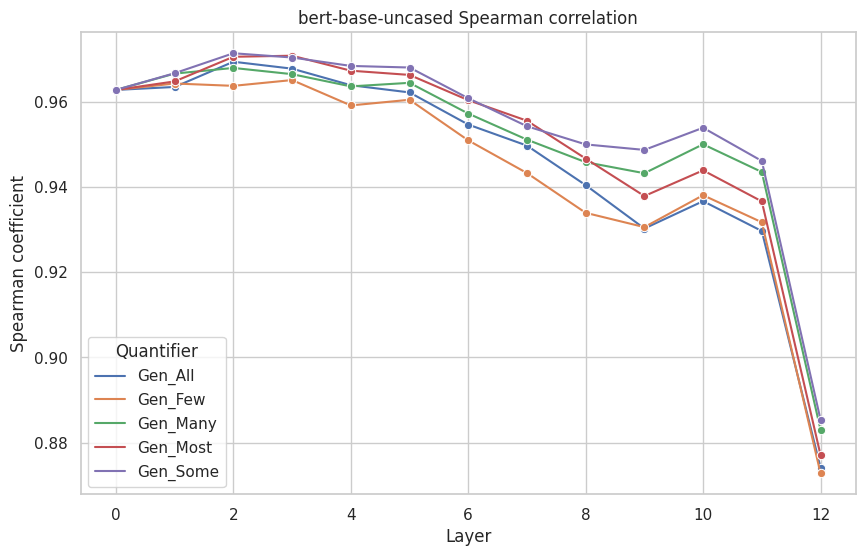

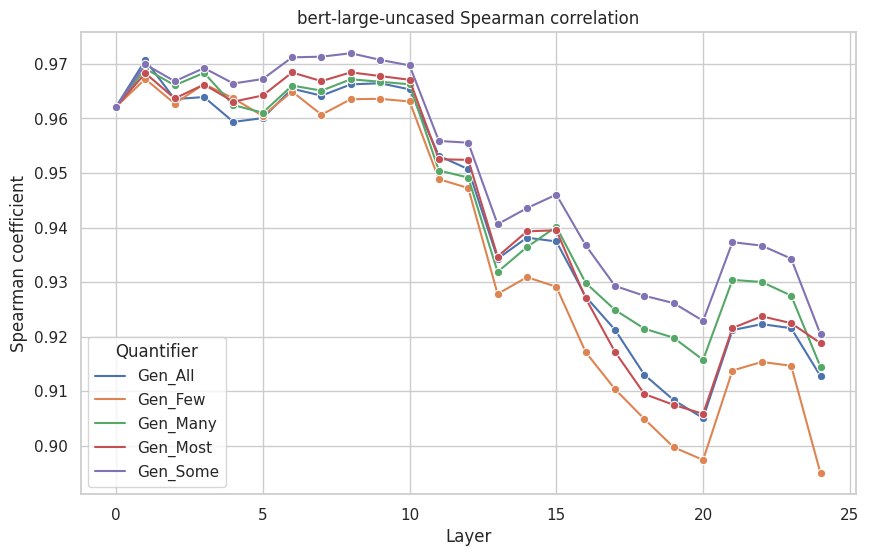

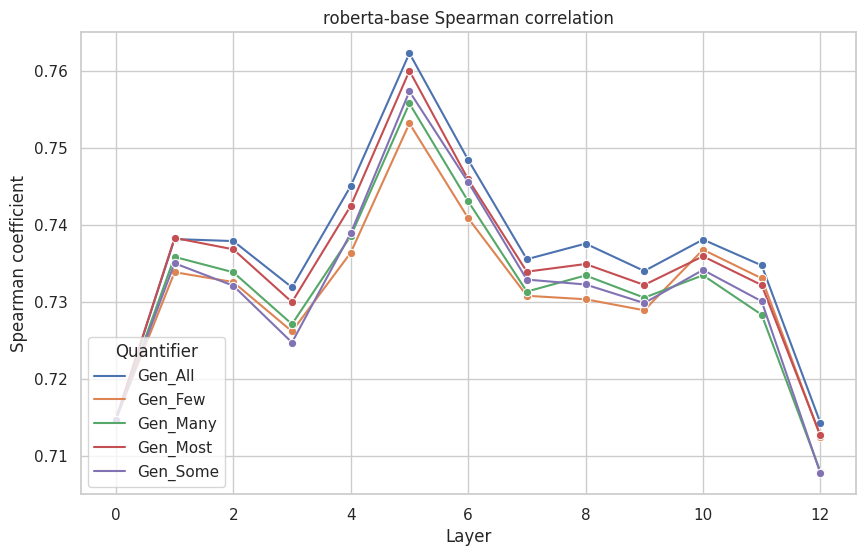

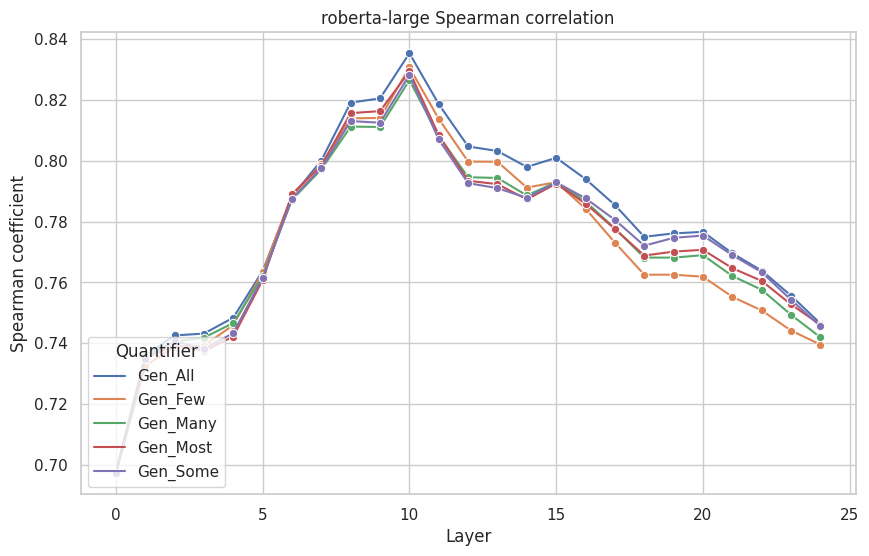

In [ ]:
for model, spearman_df in spearman_dfs.items():
    grouped_df = spearman_df.groupby(['quantifier', 'layer'])['spearman_correlation'].mean().reset_index()

    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grouped_df, x='layer', y='spearman_correlation', hue='quantifier', marker='o')

    plt.xlabel('Layer')
    plt.ylabel('Spearman coefficient')
    plt.title(f'{model} Spearman correlation')
    plt.legend(title='Quantifier', loc='lower left')

    plt.show()

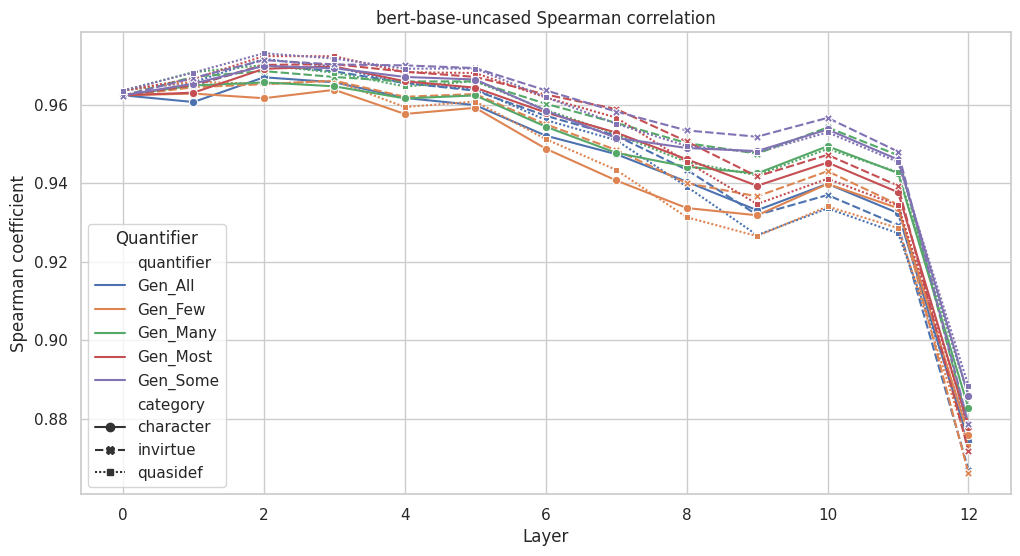

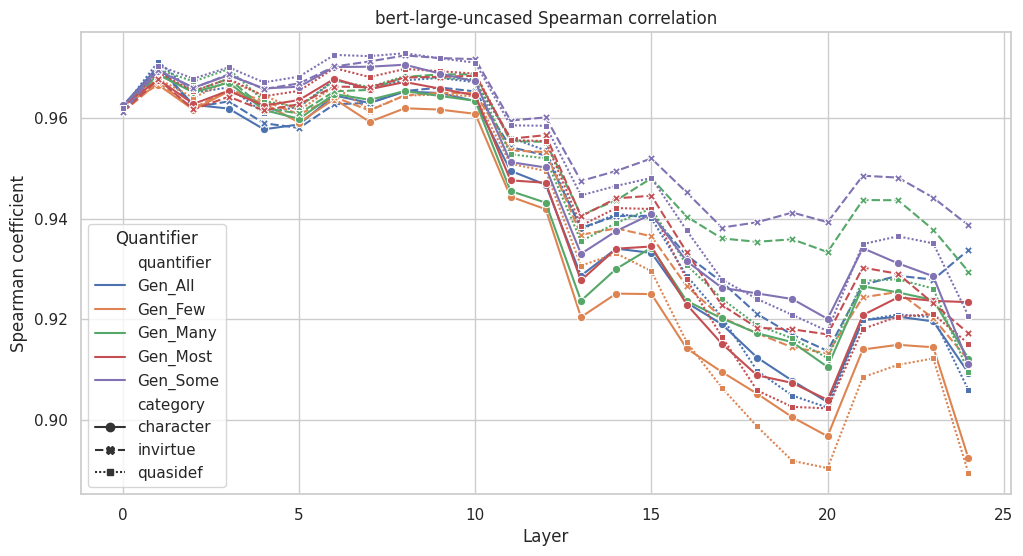

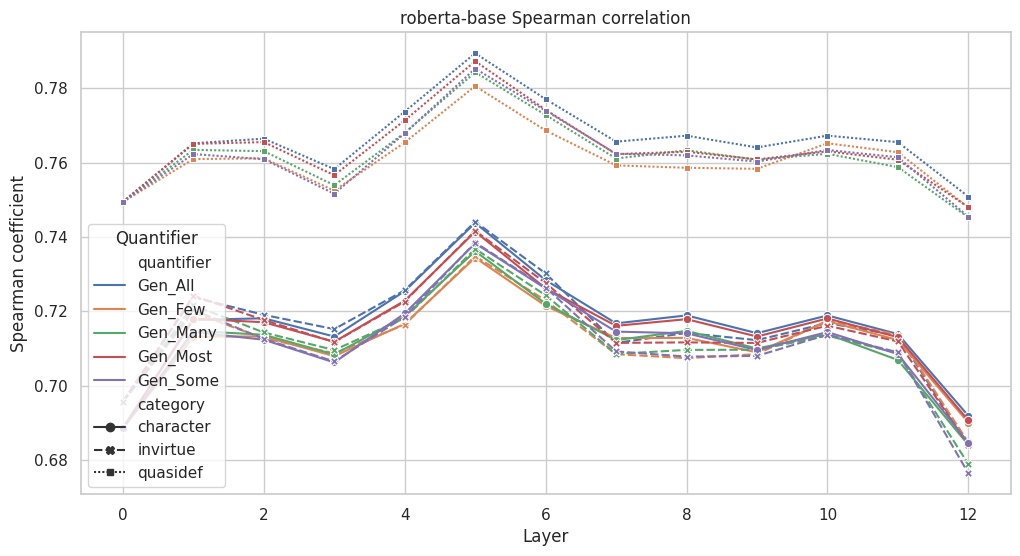

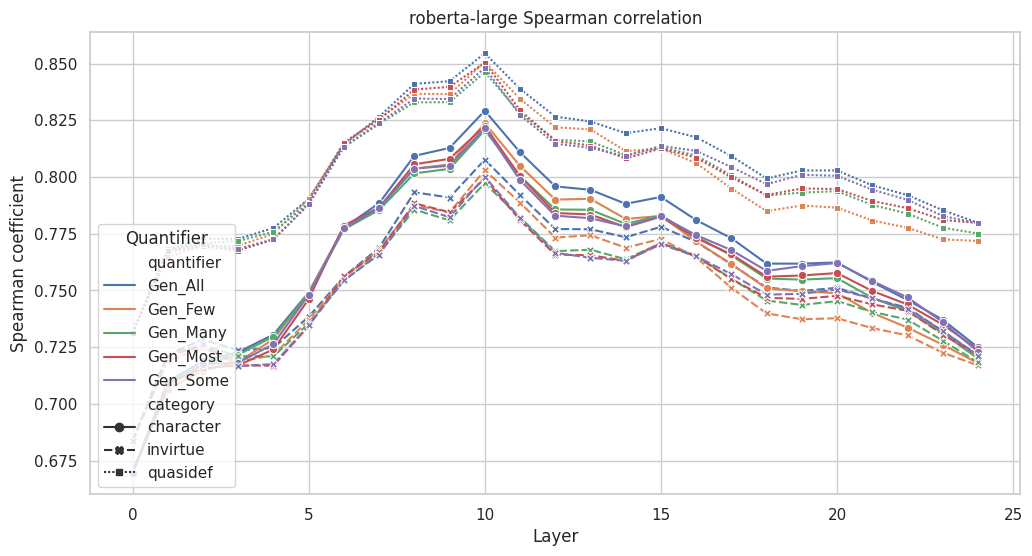

In [ ]:
for model, spearman_df in spearman_dfs.items():
    grouped_df = spearman_df.groupby(['category', 'quantifier', 'layer'])['spearman_correlation'].mean().reset_index()

    sns.set(style='whitegrid')
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=grouped_df, x='layer', y='spearman_correlation', hue='quantifier', style='category', markers=True)

    plt.xlabel('Layer')
    plt.ylabel('Spearman coefficient')
    plt.title(f'{model} Spearman correlation')
    plt.legend(title='Quantifier', loc='lower left')

    plt.show()

**Experiment 3: Implied Prevalence effects in MLMs**

In [ ]:
result_dfs = {}

for model in models:

  nlp = pipeline("fill-mask", model=model)

  columns = ["gen_sent", "category", "subject", "masked_sent",
             "few_prob", "some_prob", "many_prob", "most_prob", "all_prob"]

  result_dfs[model] = pd.DataFrame(columns=columns)

  for input_sample in processed_dataset:
    if 'roberta' in model:
      mask = '<mask> '
    else:
      mask = '[MASK] '
    sentence = input_sample[0].lower() + 'means that' + mask + input_sample[0].lower()

    targets = ("few", "some", "many", "most", "all")
    dict_results = {"gen_sent":[input_sample[0]],
                    "category": [input_sample[1]],
                    "subject": [input_sample[2]],
                    "masked_sent": [sentence]}

    # Get predictions and store them in the dictionary
    predictions = nlp(sentence, targets=targets)

    for pred in predictions:
      token = pred["token_str"]
      prob = pred["score"]
      if token == "few":
        dict_results["few_prob"] = [prob]
      elif token == "some":
        dict_results["some_prob"] = [prob]
      elif token == "many":
        dict_results["many_prob"] = [prob]
      elif token == "most":
        dict_results["most_prob"] = [prob]
      else:
        dict_results["all_prob"] = [prob]

    result_dfs[model] = pd.concat([result_dfs[model], pd.DataFrame(dict_results)])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model 

In [ ]:
for model, result_df in result_dfs.items():
    result_df.to_csv(results_folder + model + "_results_exp3.csv", sep='\t', index=False)

Visualize log probabilities

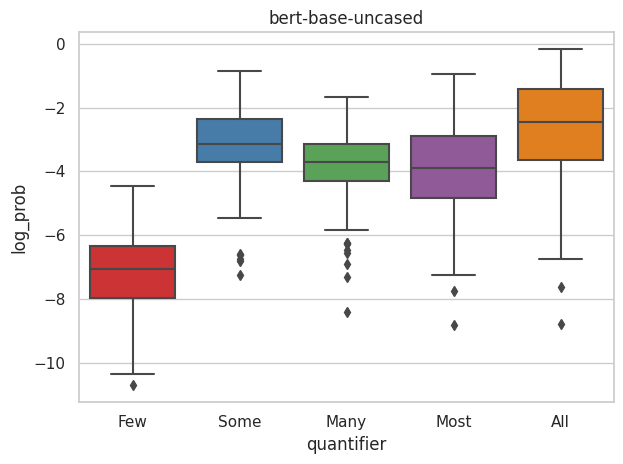

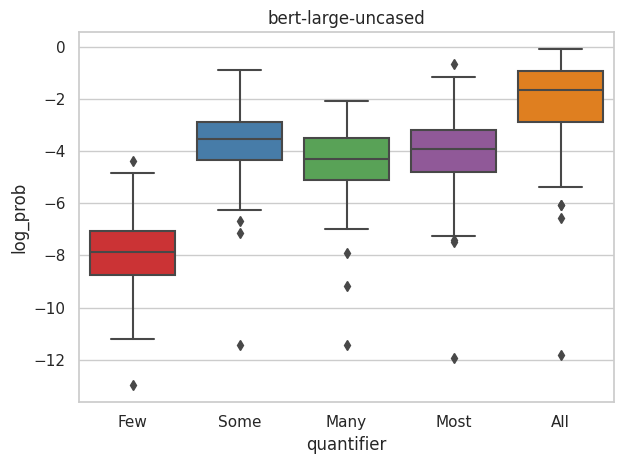

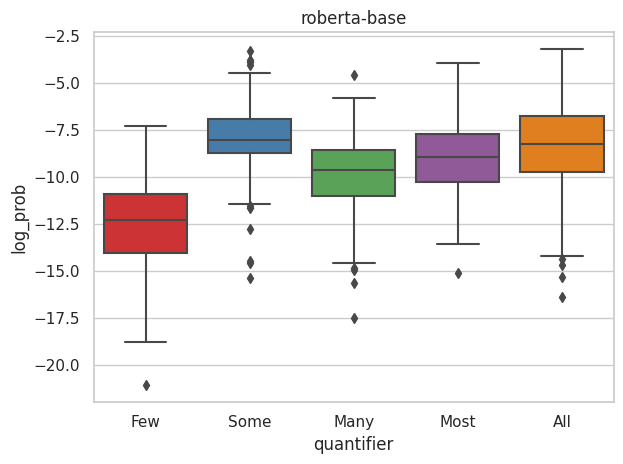

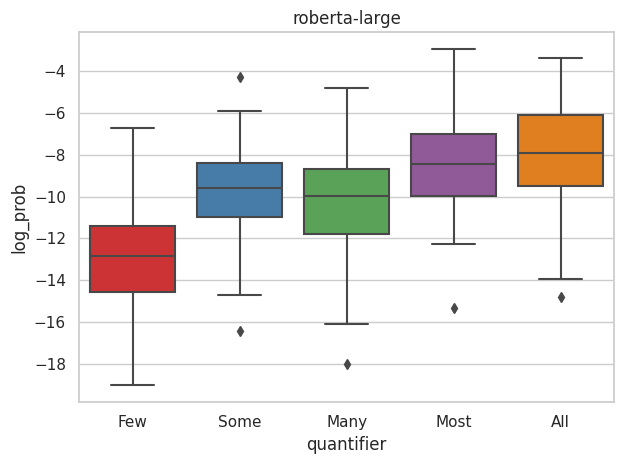

In [ ]:
boxplots = []

for model in models:
    result_df = pd.read_csv(results_folder + model + "_results_exp3.csv", sep='\t')

    data = result_df.iloc[:, -5:]
    data = data.melt(var_name='quantifier', value_name='prob')
    data['prob'] = np.log(data['prob'])

    sns.set(style='whitegrid')
    sns.set_palette("Set1")
    plt.figure()
    ax = sns.boxplot(data=data, x='quantifier', y='prob')
    plt.xlabel('quantifier')
    plt.ylabel('log_prob')
    ax.set_xticklabels(["Few", "Some", "Many", "Most", "All"])
    plt.title(f'{model}')
    plt.tight_layout()

    boxplots.append(plt)

for boxplot in boxplots:
    boxplot.show()